In [2]:
#SETUP DATASET


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

# Set random seeds for reproducibility
SEED = 1337
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Task 1: Custom Make-Moons Generator

def make_moons_custom(n_samples_0, n_samples_1, noise, random_state):
    np.random.seed(random_state)
    outer_linspace = np.linspace(0, np.pi, n_samples_0)
    X_outer = np.array([np.cos(outer_linspace), np.sin(outer_linspace)]).T
    inner_linspace = np.linspace(0, np.pi, n_samples_1)
    X_inner = np.array([1 - np.cos(inner_linspace), 1 - np.sin(inner_linspace) - 0.5]).T

    X = np.vstack((X_outer, X_inner))
    y = np.hstack((np.zeros(n_samples_0), np.ones(n_samples_1)))
    X += np.random.normal(scale=noise, size=X.shape)

    return X, y

N_TRAIN_VAL = 500
N_TEST = 500

X_train_val, y_train_val = make_moons_custom(
    n_samples_0=N_TRAIN_VAL // 2,
    n_samples_1=N_TRAIN_VAL - (N_TRAIN_VAL // 2),
    noise=0.2,
    random_state=SEED
)

# Test sets with varying noise
X_test_01, y_test_01 = make_moons_custom(N_TEST // 2, N_TEST - (N_TEST // 2), noise=0.1, random_state=SEED + 1)
X_test_02, y_test_02 = make_moons_custom(N_TEST // 2, N_TEST - (N_TEST // 2), noise=0.2, random_state=SEED + 2)
X_test_03, y_test_03 = make_moons_custom(N_TEST // 2, N_TEST - (N_TEST // 2), noise=0.3, random_state=SEED + 3)


X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.2,
    random_state=SEED,
    stratify=y_train_val
)

# Standardize Data
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_01_s = scaler.transform(X_test_01)
X_test_02_s = scaler.transform(X_test_02)
X_test_03_s = scaler.transform(X_test_03)

# Convert to PyTorch Tensors
def to_tensor(X, y):
    return (
        torch.tensor(X, dtype=torch.float32).to(device),
        torch.tensor(y, dtype=torch.float32).to(device).view(-1, 1)
    )

X_train_t, y_train_t = to_tensor(X_train_s, y_train)
X_val_t, y_val_t = to_tensor(X_val_s, y_val)
X_test_01_t, y_test_01_t = to_tensor(X_test_01_s, y_test_01)
X_test_02_t, y_test_02_t = to_tensor(X_test_02_s, y_test_02)
X_test_03_t, y_test_03_t = to_tensor(X_test_03_s, y_test_03)

print(f"Train shape: {X_train_t.shape}, Val shape: {X_val_t.shape}, Test shape: {X_test_02_t.shape}")

Train shape: torch.Size([400, 2]), Val shape: torch.Size([100, 2]), Test shape: torch.Size([500, 2])


In [3]:
#MLP Model Architecture

class SimpleMLP(nn.Module):
    def __init__(self, input_dim=2, hidden1=64, hidden2=32, output_dim=1):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, output_dim)
        )

    def forward(self, x):
        return torch.sigmoid(self.net(x))

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

#   Training Loop
def train_model(model, X_train, y_train, X_val, y_val,
                lr=1e-3, epochs=5000, patience=50,
                l1_lambda=0.0, l2_lambda=0.0, verbose=False):

    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2_lambda) # L2 is weight_decay

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()

        # Forward pass
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        # adding L1 penalty
        if l1_lambda > 0:
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss += l1_lambda * l1_norm

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val)
            val_loss = criterion(y_val_pred, y_val).item()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            if verbose:
                print(f"Early stopping at epoch {epoch}")
            break

    model.load_state_dict(best_model_state)
    return model

#  Helper function to get model predictions
def get_preds(model, X_tensor):
    model.eval()
    with torch.no_grad():
        probs = model(X_tensor).cpu().numpy()
    preds = (probs > 0.5).astype(int)
    return probs, preds

# Helper function to get sparsity
def get_sparsity(model, threshold=1e-5):
    sparsity_data = {}
    for name, param in model.named_parameters():
        if 'weight' in name:
            total = param.numel()
            zeros = (param.abs() < threshold).sum().item()
            sparsity_data[name] = zeros / total
    return sparsity_data

In [4]:
#Model 1

model_es = SimpleMLP()
train_model(
    model_es, X_train_t, y_train_t, X_val_t, y_val_t,
    patience=50, l1_lambda=0.0, l2_lambda=0.0
)
params_es = count_parameters(model_es)
print(f"Model 1 (MLP + ES) trained. Params: {params_es}")

Model 1 (MLP + ES) trained. Params: 2305


In [5]:
#Model 2

l1_grid = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
l1_results = []

print("\n--- Training Model 2 (L1 Grid Search) ---")
for l1_lambda in l1_grid:
    torch.manual_seed(SEED)
    model_l1 = SimpleMLP()

    train_model(
        model_l1, X_train_t, y_train_t, X_val_t, y_val_t,
        patience=50, l1_lambda=l1_lambda, l2_lambda=0.0
    )

    val_probs, _ = get_preds(model_l1, X_val_t)
    val_auroc = roc_auc_score(y_val, val_probs)
    sparsity = get_sparsity(model_l1)

    l1_results.append({
        "lambda": l1_lambda,
        "val_auroc": val_auroc,
        "sparsity": sparsity,
        "model": model_l1
    })
    print(f"  Lambda: {l1_lambda:<8} | Val AUROC: {val_auroc:.4f}")

# Select best L1 model
best_l1_result = max(l1_results, key=lambda x: x['val_auroc'])
model_l1_best = best_l1_result['model']
best_l1_lambda = best_l1_result['lambda']
params_l1 = count_parameters(model_l1_best)

print(f"Best L1 Lambda: {best_l1_lambda} (Val AUROC: {best_l1_result['val_auroc']:.4f})")


--- Training Model 2 (L1 Grid Search) ---
  Lambda: 1e-06    | Val AUROC: 0.9932
  Lambda: 3e-06    | Val AUROC: 0.9932
  Lambda: 1e-05    | Val AUROC: 0.9948
  Lambda: 3e-05    | Val AUROC: 0.9952
  Lambda: 0.0001   | Val AUROC: 0.9960
  Lambda: 0.0003   | Val AUROC: 0.9968
Best L1 Lambda: 0.0003 (Val AUROC: 0.9968)


In [6]:
#Model 3

l2_grid = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]
l2_results = []

print("\n--- Training Model 3 (L2 Grid Search) ---")
for l2_lambda in l2_grid:
    torch.manual_seed(SEED)
    model_l2 = SimpleMLP()

    train_model(
        model_l2, X_train_t, y_train_t, X_val_t, y_val_t,
        patience=50, l1_lambda=0.0, l2_lambda=l2_lambda
    )

    val_probs, _ = get_preds(model_l2, X_val_t)
    val_auroc = roc_auc_score(y_val, val_probs)

    l2_results.append({
        "lambda": l2_lambda,
        "val_auroc": val_auroc,
        "model": model_l2
    })
    print(f"  Lambda: {l2_lambda:<8} | Val AUROC: {val_auroc:.4f}")

# Selecting best L2 model
best_l2_result = max(l2_results, key=lambda x: x['val_auroc'])
model_l2_best = best_l2_result['model']
best_l2_lambda = best_l2_result['lambda']
params_l2 = count_parameters(model_l2_best)

print(f"Best L2 Lambda: {best_l2_lambda} (Val AUROC: {best_l2_result['val_auroc']:.4f})")


--- Training Model 3 (L2 Grid Search) ---
  Lambda: 1e-05    | Val AUROC: 0.9936
  Lambda: 0.0001   | Val AUROC: 0.9936
  Lambda: 0.001    | Val AUROC: 0.9960
  Lambda: 0.01     | Val AUROC: 0.9944
  Lambda: 0.1      | Val AUROC: 0.9480
  Lambda: 1.0      | Val AUROC: 0.9516
Best L2 Lambda: 0.001 (Val AUROC: 0.9960)


In [7]:
#Model 4

model_logit = Pipeline([
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('logit', LogisticRegression(max_iter=2000, random_state=SEED, solver='liblinear'))
])

model_logit.fit(X_train_s, y_train)

n_features = model_logit.named_steps['poly'].n_output_features_
params_logit = model_logit.named_steps['logit'].coef_.size + model_logit.named_steps['logit'].intercept_.size

print(f"\nModel 4 (LogReg + Poly) trained. Params: {params_logit}")


Model 4 (LogReg + Poly) trained. Params: 10


<>:15: SyntaxWarning: invalid escape sequence '\l'
<>:33: SyntaxWarning: invalid escape sequence '\l'
<>:15: SyntaxWarning: invalid escape sequence '\l'
<>:33: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-1170502692.py:15: SyntaxWarning: invalid escape sequence '\l'
  ax1.set_xlabel('L1 Lambda ($\lambda$)')
/tmp/ipython-input-1170502692.py:33: SyntaxWarning: invalid escape sequence '\l'
  fig.suptitle('L1 Regularization: AUROC and Sparsity vs. $\lambda$', fontsize=16)


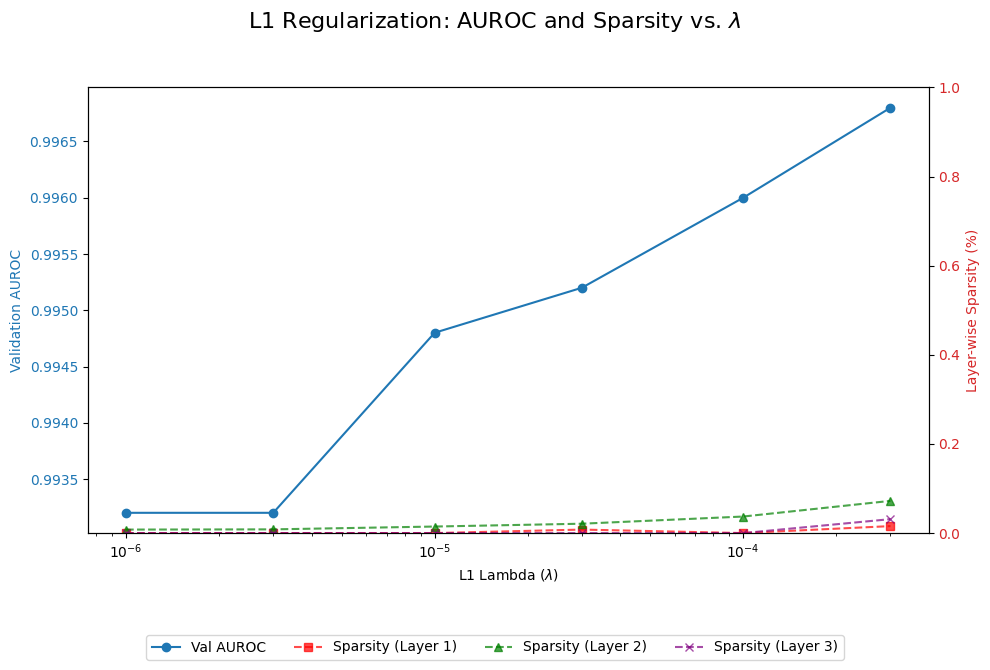

In [8]:
#L1 regularization


# Plotting
l1_df = pd.DataFrame([{
    'lambda': r['lambda'],
    'val_auroc': r['val_auroc'],
    'sparsity_layer1': r['sparsity']['net.0.weight'],
    'sparsity_layer2': r['sparsity']['net.2.weight'],
    'sparsity_layer3': r['sparsity']['net.4.weight']
} for r in l1_results])

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_xscale('log')
ax1.set_xlabel('L1 Lambda ($\lambda$)')

# Plot AUROC
color = 'tab:blue'
ax1.set_ylabel('Validation AUROC', color=color)
ax1.plot(l1_df['lambda'], l1_df['val_auroc'], 'o-', color=color, label='Val AUROC')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for sparsity
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Layer-wise Sparsity (%)', color=color)
ax2.plot(l1_df['lambda'], l1_df['sparsity_layer1'], 's--', color='red', alpha=0.7, label='Sparsity (Layer 1)')
ax2.plot(l1_df['lambda'], l1_df['sparsity_layer2'], '^--', color='green', alpha=0.7, label='Sparsity (Layer 2)')
ax2.plot(l1_df['lambda'], l1_df['sparsity_layer3'], 'x--', color='purple', alpha=0.7, label='Sparsity (Layer 3)')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 1)

fig.suptitle('L1 Regularization: AUROC and Sparsity vs. $\lambda$', fontsize=16)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [9]:
# Accuracy Evaluation fxn


def evaluate_models(models, test_sets_s, test_sets_t, test_sets_y):
    results = []

    for model_name, model_data in models.items():
        model = model_data['model']
        params = model_data['params']

        row = {"Model": model_name, "Parameters": params}

        for noise, X_s, X_t, y in zip(test_sets_s.keys(), test_sets_s.values(), test_sets_t.values(), test_sets_y.values()):
            if isinstance(model, Pipeline):
                # using Sklearn models
                acc = model.score(X_s, y)
            else:
                # PyTorch models
                _, preds = get_preds(model, X_t)
                acc = accuracy_score(y, preds)
            row[f"Accuracy (Noise={noise})"] = acc
        results.append(row)

    return pd.DataFrame(results).set_index("Model")

models_dict = {
    "MLP (Early Stop)": {"model": model_es, "params": params_es},
    "MLP (L1)": {"model": model_l1_best, "params": params_l1},
    "MLP (L2)": {"model": model_l2_best, "params": params_l2},
    "LogReg (Poly)": {"model": model_logit, "params": params_logit}
}

test_sets_scaled = {"0.1": X_test_01_s, "0.2": X_test_02_s, "0.3": X_test_03_s}
test_sets_tensor = {"0.1": X_test_01_t, "0.2": X_test_02_t, "0.3": X_test_03_t}
test_sets_numpy = {"0.1": y_test_01, "0.2": y_test_02, "0.3": y_test_03}

accuracy_table = evaluate_models(models_dict, test_sets_scaled, test_sets_tensor, test_sets_numpy)
print("\n--- Test Accuracy and Robustness Table ---")
print(accuracy_table.to_markdown(floatfmt=".4f"))


--- Test Accuracy and Robustness Table ---
| Model            |   Parameters |   Accuracy (Noise=0.1) |   Accuracy (Noise=0.2) |   Accuracy (Noise=0.3) |
|:-----------------|-------------:|-----------------------:|-----------------------:|-----------------------:|
| MLP (Early Stop) |    2305.0000 |                 0.9980 |                 0.9580 |                 0.9060 |
| MLP (L1)         |    2305.0000 |                 0.9960 |                 0.9560 |                 0.9060 |
| MLP (L2)         |    2305.0000 |                 0.9980 |                 0.9600 |                 0.9060 |
| LogReg (Poly)    |      10.0000 |                 0.9900 |                 0.9580 |                 0.9140 |


<>:28: SyntaxWarning: invalid escape sequence '\l'
<>:29: SyntaxWarning: invalid escape sequence '\l'
<>:28: SyntaxWarning: invalid escape sequence '\l'
<>:29: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-2606912508.py:28: SyntaxWarning: invalid escape sequence '\l'
  plot_decision_boundary(model_l1_best, X_test_02_s, y_test_02, axes[1], f"MLP (L1, $\lambda$={best_l1_lambda})")
/tmp/ipython-input-2606912508.py:29: SyntaxWarning: invalid escape sequence '\l'
  plot_decision_boundary(model_l2_best, X_test_02_s, y_test_02, axes[2], f"MLP (L2, $\lambda$={best_l2_lambda})")


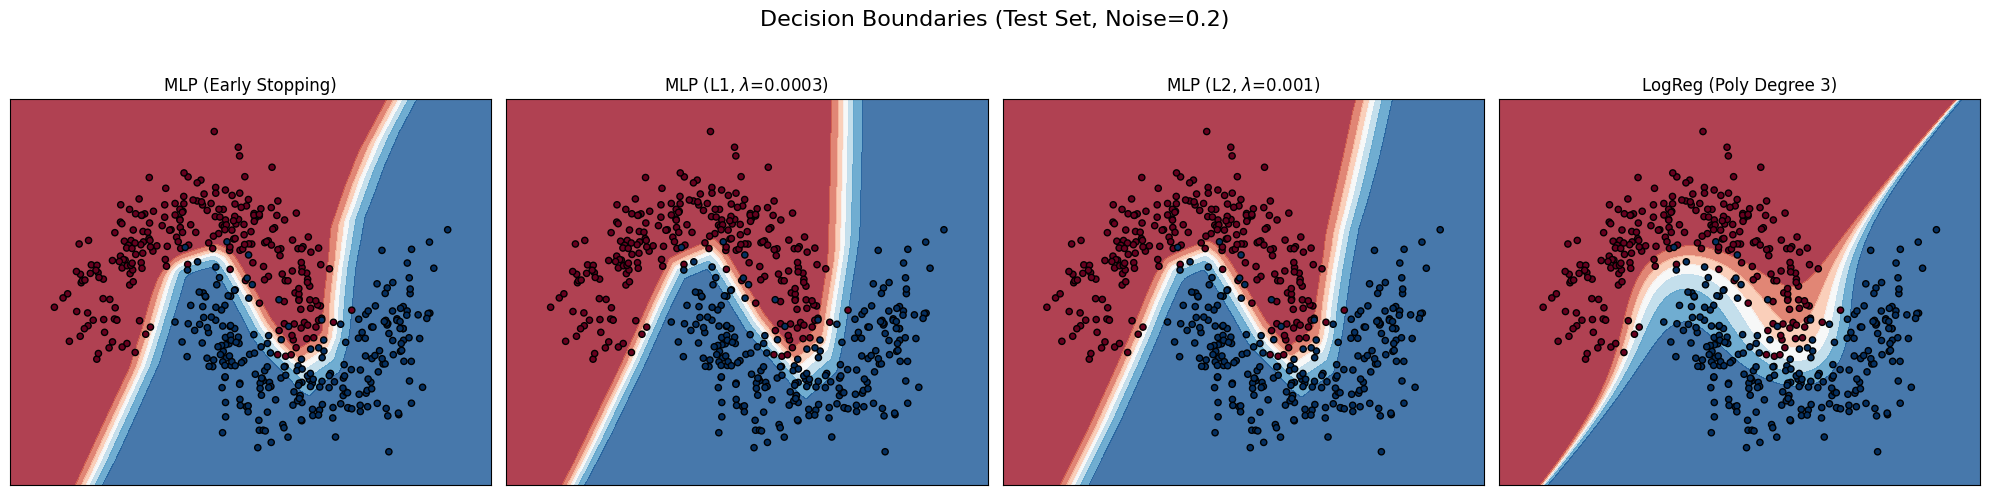

In [10]:
#Decision Boundary Plot

def plot_decision_boundary(model, X, y, ax, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    mesh_data = np.c_[xx.ravel(), yy.ravel()]

    if isinstance(model, Pipeline):
        Z = model.predict_proba(mesh_data)[:, 1]
    else:
        mesh_tensor = torch.tensor(mesh_data, dtype=torch.float32).to(device)
        Z, _ = get_preds(model, mesh_tensor)

    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.8)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu, edgecolors='k', s=20)
    ax.set_title(title)
    ax.set_xticks(())
    ax.set_yticks(())

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

plot_decision_boundary(model_es, X_test_02_s, y_test_02, axes[0], "MLP (Early Stopping)")
plot_decision_boundary(model_l1_best, X_test_02_s, y_test_02, axes[1], f"MLP (L1, $\lambda$={best_l1_lambda})")
plot_decision_boundary(model_l2_best, X_test_02_s, y_test_02, axes[2], f"MLP (L2, $\lambda$={best_l2_lambda})")
plot_decision_boundary(model_logit, X_test_02_s, y_test_02, axes[3], "LogReg (Poly Degree 3)")

plt.suptitle("Decision Boundaries (Test Set, Noise=0.2)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [11]:
#effect of class imbalance
#Splitting into 70,30

N_0 = int(N_TRAIN_VAL * 0.7) # 350
N_1 = N_TRAIN_VAL - N_0      # 150

X_train_val_im, y_train_val_im = make_moons_custom(
    n_samples_0=N_0,
    n_samples_1=N_1,
    noise=0.2,
    random_state=SEED + 10
)

X_train_im, X_val_im, y_train_im, y_val_im = train_test_split(
    X_train_val_im, y_train_val_im,
    test_size=0.2,
    random_state=SEED,
    stratify=y_train_val_im
)

scaler_im = StandardScaler()
X_train_im_s = scaler_im.fit_transform(X_train_im)
X_val_im_s = scaler_im.transform(X_val_im)

# **Crucial**: Scale the balanced test set using the *imbalanced* train stats
X_test_02_im_s = scaler_im.transform(X_test_02)

X_train_im_t, y_train_im_t = to_tensor(X_train_im_s, y_train_im)
X_val_im_t, y_val_im_t = to_tensor(X_val_im_s, y_val_im)
X_test_02_im_t, y_test_02_im_t = to_tensor(X_test_02_im_s, y_test_02)

print(f"\n--- Retraining on Imbalanced Data (70:30) ---")

#retrain all 4 models

# Model 1
torch.manual_seed(SEED)
model_es_im = SimpleMLP()
train_model(model_es_im, X_train_im_t, y_train_im_t, X_val_im_t, y_val_im_t, patience=50)

# Model 2
torch.manual_seed(SEED)
model_l1_im = SimpleMLP()
train_model(model_l1_im, X_train_im_t, y_train_im_t, X_val_im_t, y_val_im_t,
            patience=50, l1_lambda=best_l1_lambda)

# Model 3
torch.manual_seed(SEED)
model_l2_im = SimpleMLP()
train_model(model_l2_im, X_train_im_t, y_train_im_t, X_val_im_t, y_val_im_t,
            patience=50, l2_lambda=best_l2_lambda)

# Model 4
model_logit_im = Pipeline([
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('logit', LogisticRegression(max_iter=2000, random_state=SEED, solver='liblinear'))
])
model_logit_im.fit(X_train_im_s, y_train_im)

print("Retraining complete.")


imbalanced_results = []
models_im_dict = {
    "MLP (Early Stop)": model_es_im,
    "MLP (L1)": model_l1_im,
    "MLP (L2)": model_l2_im,
    "LogReg (Poly)": model_logit_im
}

y_true_test = y_test_02

for name, model in models_im_dict.items():
    if isinstance(model, Pipeline):
        probs = model.predict_proba(X_test_02_im_s)[:, 1]
        preds = model.predict(X_test_02_im_s)
    else:
        probs, preds = get_preds(model, X_test_02_im_t)
        probs = probs.flatten()
        preds = preds.flatten()

    acc = accuracy_score(y_true_test, preds)
    auroc = roc_auc_score(y_true_test, probs)
    imbalanced_results.append({"Model": name, "Accuracy": acc, "AUROC": auroc})

imbalance_table = pd.DataFrame(imbalanced_results).set_index("Model")
print("\n--- Evaluation on Balanced Test Set (Models trained on 70:30 Imbalance) ---")
print(imbalance_table.to_markdown(floatfmt=".4f"))


--- Retraining on Imbalanced Data (70:30) ---
Retraining complete.

--- Evaluation on Balanced Test Set (Models trained on 70:30 Imbalance) ---
| Model            |   Accuracy |   AUROC |
|:-----------------|-----------:|--------:|
| MLP (Early Stop) |     0.9620 |  0.9956 |
| MLP (L1)         |     0.9620 |  0.9953 |
| MLP (L2)         |     0.9600 |  0.9955 |
| LogReg (Poly)    |     0.9440 |  0.9928 |
